In [126]:
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statistics
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Connect to database
#conn = sqlite3.connect("/home/runner/work/aiap20-jaye-lin-jiaqi-945I/aiap20-jaye-lin-jiaqi-945I/data/bmarket.db")
conn = sqlite3.connect("/Users/jayelin/Downloads/docker_image/data/bmarket.db")

# Fetch all rows from the 'bank_marketing' table
cursor = conn.cursor()

cursor.execute("SELECT * FROM bank_marketing") # cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
rows = cursor.fetchall()

# Create DataFrame from the results
columns = [description[0] for description in cursor.description]  # Get column names
df = pd.DataFrame(rows, columns=columns)

In [127]:
def contact_method_cleaning(mobile_str):
    if mobile_str == 'Telephone':
        return 'telephone'
    elif mobile_str == 'Cell':
        return 'cellular'
    else:
        return mobile_str

def contact_binary(str):
    if str == 'telephone':
        return 1
    elif str == 'cellular':
        return 2

def yes_no_binary(yes_no_str):
    if yes_no_str == 'no':
        return 0
    elif yes_no_str == 'yes':
        return 1
    else:
        return -1
    
def occupation_mapping(str):
    if str == 'student':
        return 1
    elif str == 'unemployed':
        return 2
    elif str == 'housemaid':
        return 3
    elif str == 'blue-collar':
        return 4
    elif str == 'technician':
        return 5
    elif str == 'services':
        return 6
    elif str == 'admin.':
        return 7
    elif str == 'retired':
        return 8
    elif str == 'self-employed':
        return 9
    elif str == 'management':
        return 10
    elif str == 'entrepreneur':
        return 11
    elif str == 'unknown':
        return -1

def marital_mapping(str):
    if str == 'married':
        return 1
    elif str == 'divorced':
        return 2
    elif str == 'single':
        return 3
    elif str == 'unknown':
        return -1

def education_mapping(education_str):
    mapping = {
        'illiterate': 1,
        'basic.4y': 2,
        'basic.6y': 3,
        'basic.9y': 4,
        'high.school': 5,
        'professional.course': 6,
        'university.degree': 7,
        'unknown': -1
    }
    return mapping.get(education_str, -1)

def previous_contact_days_mapping(contact_days):
    return -1 if contact_days == 999 else contact_days

df['Contact Method'] = df['Contact Method'].apply(contact_method_cleaning)
#df['Contact Method'] = df['Contact Method'].apply(contact_binary)
df['Housing Loan'] = df['Housing Loan'].apply(yes_no_binary)
df['Personal Loan'] = df['Personal Loan'].apply(yes_no_binary)
df['Credit Default'] = df['Credit Default'].apply(yes_no_binary)
df['Subscription Status'] = df['Subscription Status'].apply(yes_no_binary)
#df['Occupation'] = df['Occupation'].apply(occupation_mapping)
#df['Marital Status'] = df['Marital Status'].apply(marital_mapping)
df['Age'] = df['Age'].str.extract(r'(\d+)').astype(int)
df['Education Level'] = df['Education Level'].apply(education_mapping)
df['Previous Contact Days'] = df['Previous Contact Days'].apply(previous_contact_days_mapping)

df = pd.get_dummies(df, columns=['Occupation'], prefix='occupation')
df = pd.get_dummies(df, columns=['Marital Status'], prefix='marital_status')
df = pd.get_dummies(df, columns=['Contact Method'], prefix='contact_method')

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n--- Evaluation: {model.__class__.__name__} ---")
    if preds_proba is not None:
        auc = roc_auc_score(y_test, preds_proba)
        print('AUC-ROC:', auc)

    print('Accuracy:', accuracy_score(y_test, preds))
    print('Precision:', precision_score(y_test, preds))
    print('Recall:', recall_score(y_test, preds))
    print('F1 Score:', f1_score(y_test, preds))
    print('Confusion Matrix:\n', confusion_matrix(y_test, preds))

df.head(5)

,Client ID,Age,Education Level,Credit Default,Housing Loan,Personal Loan,Campaign Calls,Previous Contact Days,Subscription Status,occupation_admin.,...,occupation_student,occupation_technician,occupation_unemployed,occupation_unknown,marital_status_divorced,marital_status_married,marital_status_single,marital_status_unknown,contact_method_cellular,contact_method_telephone
0,32885,57,5,0,0,1,1,-1,0,False,...,False,True,False,False,False,True,False,False,True,False
1,3170,55,-1,-1,1,0,2,-1,0,False,...,False,False,False,True,False,True,False,False,False,True
2,32207,33,4,0,0,0,1,-1,0,False,...,False,False,False,False,False,True,False,False,True,False
3,9404,36,5,0,0,0,4,-1,0,True,...,False,False,False,False,False,True,False,False,False,True
4,14021,27,5,0,-1,0,2,-1,0,False,...,False,False,False,False,False,True,False,False,True,False


In [ ]:
# KNN
# Build machine learning models and evaluate with AUC metric

X = df.drop(columns='Subscription Status')
y = df['Subscription Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Instantiate the model object
knn_model = KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')

# Train model
knn_model.fit(X_train, y_train)

# Predict the target on the test dataset
knn_preds = knn_model.predict_proba(X_test)[:, 1]

evaluate_model(knn_model, X_test, y_test)




--- Evaluation: KNeighborsClassifier ---
AUC-ROC: 0.7733103566205952
Accuracy: 0.8926924010682205
Precision: 0.5647058823529412
Recall: 0.20689655172413793
F1 Score: 0.3028391167192429
Confusion Matrix:
 [[7162  148]
 [ 736  192]]


In [ ]:
# Logistic Regression Model

X = df.drop(columns=['Subscription Status', 'Age'])
y = df['Subscription Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Instantiate the model object
lr_model = LogisticRegression(class_weight='balanced', max_iter=700, C=10, solver='liblinear', penalty='l1')

lr_model.fit(X_train, y_train)

# Predict the target on the test dataset
lr_preds = lr_model.predict_proba(X_test)[:, 1]

evaluate_model(lr_model, X_test, y_test)


In [ ]:
# Random forest

X = df.drop(columns='Subscription Status')
y = df['Subscription Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Instantiate the model object
rf_model = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=30, max_features='sqrt', min_samples_leaf=1)

# Train Model
rf_model.fit(X_train, y_train)

# Predict the target on the test dataset
rf_preds = rf_model.predict_proba(X_test)[:, 1]

evaluate_model(rf_model, X_test, y_test)

print(rf_preds)



--- Evaluation: RandomForestClassifier ---
AUC-ROC: 0.7389732464585467
Accuracy: 0.8873512988589464
Precision: 0.4973913043478261
Recall: 0.3091891891891892
F1 Score: 0.38133333333333336
Confusion Matrix:
 [[7024  289]
 [ 639  286]]
[0.01       0.34291383 0.64333333 ... 0.17333333 0.12       0.13333333]


In [130]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Build machine learning models and evaluate with AUC metric
X = df.drop(columns='Subscription Status')
y = df['Subscription Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Instantiate the model object
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=30,
    colsample_bytree=1.0,  # Equivalent to max_features='sqrt' in RandomForest
    min_child_weight=1,    # Similar to min_samples_leaf
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train Model
xgb_model.fit(X_train, y_train)

# Predict the target on the test dataset
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
evaluate_model(xgb_model, X_test, y_test)

print(xgb_preds)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:36:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Evaluation: XGBClassifier ---
AUC-ROC: 0.7428291871078825
Accuracy: 0.8820101966496723
Precision: 0.46245733788395904
Recall: 0.2920258620689655
F1 Score: 0.3579920739762219
Confusion Matrix:
 [[6995  315]
 [ 657  271]]
[7.97241111e-04 8.18725443e-04 7.47169397e-05 ... 1.16173014e-01
 2.73574367e-02 3.76888260e-04]


Best Parameters: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__n_estimators': 300}
AUC-ROC score on the entire dataset: 0.8560322684999981


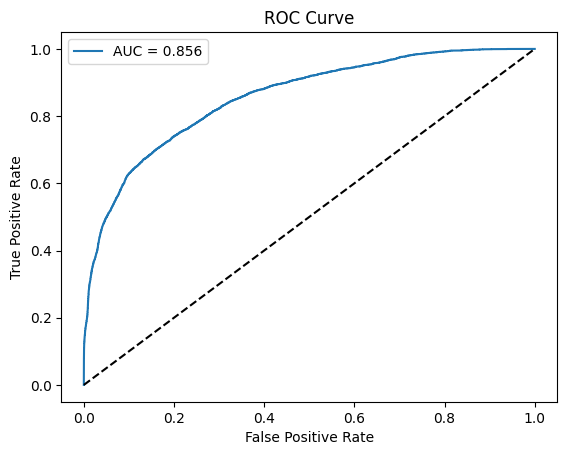

In [93]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# 1. Prepare the data
X = df.drop(columns='Subscription Status')
y = df['Subscription Status']

# 2. Build a pipeline (add scaler if needed)
pipeline = Pipeline([
    # ('scaler', StandardScaler()),  # Uncomment if features are not all categorical or tree-based
    ('clf', RandomForestClassifier(random_state=42))
])

# 3. KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Grid search for best hyperparameters with K-fold cross-validation
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)  # Fit to the entire dataset (as cross-validation is handled by GridSearchCV)

# 5. Evaluate the best model from grid search
best_model = grid_search.best_estimator_

# 6. Predict and calculate AUC-ROC score
rf_preds = best_model.predict_proba(X)[:, 1]  # Use the whole dataset predictions
auc = roc_auc_score(y, rf_preds)

print('Best Parameters:', grid_search.best_params_)
print('AUC-ROC score on the entire dataset:', auc)

# 7. Plot ROC curve
fpr, tpr, thresholds = roc_curve(y, rf_preds)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [110]:
# KNN
# Build machine learning models and evaluate with AUC metric

#X = df.drop(columns='Subscription Status')
# = df['Occupation']
X = df.drop(columns=['Client ID', 'Age', 'Marital Status', 'Education Level', 'Credit Default', 'Housing Loan', 'Personal Loan','Contact Method', 'Campaign Calls', 'Previous Contact Days',	'Subscription Status'])
y = df['Subscription Status']

#['Client ID', 'Age', 'Occupation	Marital Status	Education Level	Credit Default	Housing Loan
# ['Contact Method', 'Campaign Calls', 'Previous Contact Days',	'Subscription Status']

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# The resampled X and y are now balanced
#print(f"Original dataset shape: {y.value_counts()}")
#print(f"Resampled dataset shape: {y_resampled.value_counts()}")

# Instantiate the model object
knn_model = KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')

# Train model
knn_model.fit(X_train, y_train)

# Predict the target on the test dataset
knn_preds = knn_model.predict_proba(X_test)[:, 1]

evaluate_model(knn_model, X_test, y_test)

'''
AUC-ROC: 0.6135097026982405
Accuracy: 0.8882010196649672
Precision: 0.5714285714285714
Recall: 0.03017241379310345
F1 Score: 0.057318321392016376
Confusion Matrix:
 [[7289   21]
 [ 900   28]]
'''


--- Evaluation: KNeighborsClassifier ---
AUC-ROC: 0.5718353460068871
Accuracy: 0.8873512988589464
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[7310    0]
 [ 928    0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'\nAUC-ROC: 0.6135097026982405\nAccuracy: 0.8882010196649672\nPrecision: 0.5714285714285714\nRecall: 0.03017241379310345\nF1 Score: 0.057318321392016376\nConfusion Matrix:\n [[7289   21]\n [ 900   28]]\n'

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 30, 'knn__weights': 'uniform'}
AUC-ROC score on test set: 0.8256734212675687


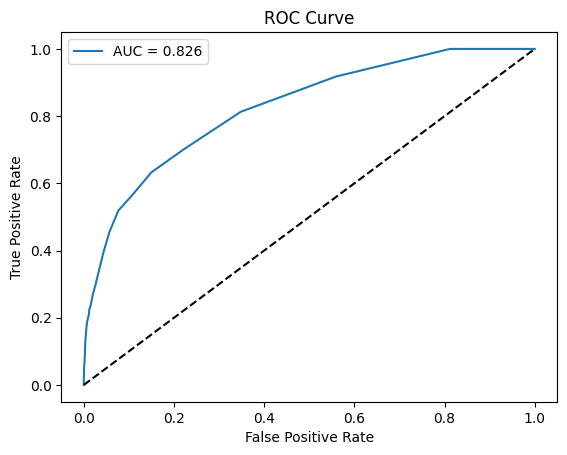

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# 1. Split data
X = df_resampled.drop(columns='Subscription Status')
y = df_resampled['Subscription Status']

# 2. Standardize features using a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the features
    ('knn', KNeighborsClassifier())  # KNN model
])

# 3. KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Define K-fold with shuffle

# 4. Hyperparameter tuning with GridSearchCV
param_grid = {
    'knn__n_neighbors': [5, 10, 20, 30],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'cosine']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)  # Fit the model to the entire dataset (as cross-validation is handled by grid_search)

# 5. Predict and evaluate using the best model
best_model = grid_search.best_estimator_
knn_preds = best_model.predict_proba(X_test)[:, 1]

# 6. Calculate AUC-ROC score on the test set
auc = roc_auc_score(y_test, knn_preds)

# Display results
print('Best Parameters:', grid_search.best_params_)
print('AUC-ROC score on test set:', auc)

# 7. Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn_preds)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



--- Evaluation: LogisticRegression ---
AUC-ROC: 0.766844839379216
Accuracy: 0.7240835154163632
Precision: 0.2478440194975628
Recall: 0.7122844827586207
F1 Score: 0.3677329624478442
Confusion Matrix:
 [[5304 2006]
 [ 267  661]]


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Split data
X = df_resampled.drop(columns='Subscription Status')
y = df_resampled['Subscription Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Set up pipeline with scaler + logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Define hyperparameter grid
param_grid = {
    'lr__C': [0.01, 0.1, 1, 10],                  # Regularization strength
    'lr__penalty': ['l1', 'l2']                   # L1 = Lasso, L2 = Ridge
}

# Set up stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Run grid search
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict on test data
lr_preds = best_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation AUC:", grid_search.best_score_)

evaluate_model(best_model, X_test, y_test)

# Test AUC-ROC
auc = roc_auc_score(y_test, lr_preds)
print('AUC-ROC score on test set:', auc)


Best hyperparameters: {'lr__C': 10, 'lr__penalty': 'l1'}
Best cross-validation AUC: 0.8452896071439078

--- Evaluation: Pipeline ---
AUC-ROC: 0.8397591053213773
Accuracy: 0.7495896032831737
Precision: 0.7837114051669817
Recall: 0.6849786589563541
F1 Score: 0.7310263757255161
Confusion Matrix:
 [[5984 1373]
 [2288 4975]]
AUC-ROC score on test set: 0.8397591053213773
